In [1]:
import numpy as np
from pylab import *
import matplotlib.pyplot as plt

In [2]:
def m_enquacao(v,vrest):
	alphaM = (2.5-0.1*(v-vrest))/(exp(2.5-.1*(v-vrest))-1)
	betaM = 4*exp((vrest-v)/18)
	return alphaM, betaM

def n_enquacao(v,vrest):
	alphaN = (0.1-0.01*(v-vrest))/(exp(1-0.1*(v-vrest))-1)
	betaN = 0.125*exp((vrest-v)/80)
	return alphaN, betaN

def h_enquacao(v,vrest):
	alphaH = 0.07*exp((vrest-v)/20)
	betaH = 1/(1+exp(3-0.1*(v-vrest)))
	return alphaH, betaH

def rolling_window(seq, window_size):
    it = iter(seq)
    win = [it.next() for cnt in xrange(window_size)] # First window
    yield win
    for e in it: # Subsequent windows
        win[:-1] = win[1:]
        win[-1] = e
        yield win

In [3]:
# Artigo base:
# https://www.math.fsu.edu/~jkimrey/journalclub/papersSP21/01_13_2021.pdf

In [4]:
vrest = -65			# potencial de repouso
dt = 0.001			# Passo da simulação 
temSim = 3000 		# Tempo total da simulação 3 segundos
c = 1				# Valor da capacitancia

In [5]:
vth = 40 		# Limiar (th) em mV do potencial de membrana do neurônio
E_Na = 115 		# Potencial de reversão do sódio (Na)
E_k = -12 			# Potencial de reversão do potássio (K)
E_Leak = -10.6 	# Potencial de reversão do escape/vazamento
g_Na = 36 				# Condutância de sódio
g_K = 12 				# Condutância de potássio
g_Leak = 0.1 			# Condutância de vazamento

## a) Implemente e simule o modelo acima por 3 segundos. Utilize o modelo de Hodgkin-Huxley com passo h=0,1 ms e Iinj=2 nA.

In [6]:
I_corrente = np.zeros(temSim+1);

for i in range(temSim+1):
    # if i > 100 and i < 300:
    # 	I_corrente[i] = 50
    I_corrente[i] = 5

In [7]:
condutancia_K = np.zeros(temSim+1)
condutancia_Na = np.zeros(temSim+1)
I_Na = np.zeros(temSim+1)
I_K = np.zeros(temSim+1)
I_Leak = np.zeros(temSim+1)

v = np.zeros(temSim+1)
m = np.zeros(temSim+1)
h = np.zeros(temSim+1)
n = np.zeros(temSim+1)

v[0] = vrest

alphaM, betaM = m_enquacao(v[0],vrest)
alphaN, betaN = n_enquacao(v[0],vrest)
alphaH, betaH = h_enquacao(v[0],vrest)

m[0] = (alphaM / (alphaM + betaM))
n[0] = (alphaN / (alphaN + betaN))
h[0] = (alphaH / (alphaH + betaH))

In [8]:
for i in range(0, temSim-1):
    alphaN, betaN = n_enquacao(v[i],vrest)
    alphaM, betaM = m_enquacao(v[i],vrest)
    alphaH, betaH = h_enquacao(v[i],vrest)

    condutancia_K[i] = g_K*(pow(n[i],4))
    condutancia_Na[i] = g_Na*(pow(m[i],3))*h[i]

    I_Na[i] = condutancia_Na[i]*(v[i]-E_Na)
    I_K[i] = condutancia_K[i]*(v[i]-E_k)
    I_Leak[i] = g_Leak*(v[i]-E_Leak)

    entrada = I_corrente[i] - (I_Na[i] + I_K[i] + I_Leak[i])

    v[i+1] = v[i] + dt * (entrada*(1/c))

    m[i+1] = m[i] + (alphaM * (1-m[i]) - betaM * m[i])*dt
    n[i+1] = n[i] + (alphaN * (1-n[i]) - betaN * n[i])*dt
    h[i+1] = h[i] + (alphaH * (1-h[i]) - betaH * h[i])*dt

    if v[i+1] > vth:
        v[i+1] = vrest

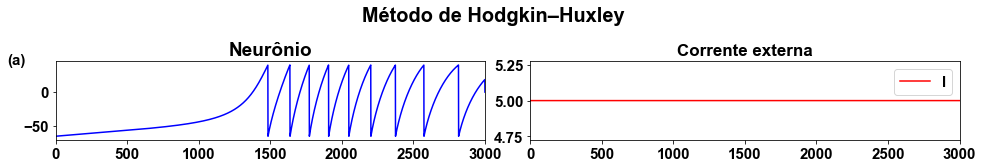

In [9]:
sizefonte = 15
font = {'family' : 'arial',
	'weight' : 'bold',
	'size'   : sizefonte}
plt.rc('font', **font)
fig = plt.figure(figsize=(13.50,8.50))
fig.subplots_adjust(left=0.05, bottom=0.07, right=0.98,
					top=0.89, wspace=0.236, hspace=0.35)

fig.suptitle('Método de Hodgkin–Huxley', fontsize=sizefonte+5, weight="bold")
linhas = 5
colunas = 4
ax1 = plt.subplot2grid((linhas, colunas), (0, 0), colspan=2)
ax1.text(-0.07, 1.1, '(a)', transform=ax1.transAxes,
	  fontsize=sizefonte, fontweight='bold', va='top', ha='right')
ax1.set_title("Neurônio", fontname='Arial',size=sizefonte+4, weight="bold")
plt.plot(v, 'b')
plt.xlim(0,temSim)
# plt.xticks([])

ax2 = plt.subplot2grid((linhas, colunas), (0, 2), colspan=2)
ax2.set_title("Corrente externa", fontname='Arial',size=sizefonte+2, weight="bold")
plt.plot(I_corrente, 'r', label='I')
ax2.legend(loc='upper right')
# plt.plot(ts, v, 'b')
plt.xlim(0,temSim);

### Essa escolha de parametros ja faz o neurônio disparar mesmo se a corrente externa injetada for igual a 0. Decidir deixar uma corrente igual a 5 para visualmente vermos que o disparo inicial esta na marca dos 1500ms

##  b) A corrente de reobase é definida como a corrente abaixo da qual o neurônio não dispara. Construa uma simulação que permita verificar, experimentalmente, o valor da corrente de reobase para os parâmetros listados. Qual o valor desta corrente?

In [14]:
v_b = np.zeros(temSim+1)
v_b[0] = vrest
alpha = np.linspace(0,5,num=temSim+1)
spikesB = np.zeros(temSim+1)
contDisparosB = 0

for i in range(0, temSim-1):
    alphaN, betaN = n_enquacao(v[i],vrest)
    alphaM, betaM = m_enquacao(v[i],vrest)
    alphaH, betaH = h_enquacao(v[i],vrest)

    condutancia_K[i] = g_K*(pow(n[i],4))
    condutancia_Na[i] = g_Na*(pow(m[i],3))*h[i]

    I_Na[i] = condutancia_Na[i]*(v[i]-E_Na)
    I_K[i] = condutancia_K[i]*(v[i]-E_k)
    I_Leak[i] = g_Leak*(v[i]-E_Leak)

    entrada = (I_corrente[i] * alpha[i])- (I_Na[i] + I_K[i] + I_Leak[i])

    v_b[i+1] = v_b[i] + dt * (entrada*(1/c))

    m[i+1] = m[i] + (alphaM * (1-m[i]) - betaM * m[i])*dt
    n[i+1] = n[i] + (alphaN * (1-n[i]) - betaN * n[i])*dt
    h[i+1] = h[i] + (alphaH * (1-h[i]) - betaH * h[i])*dt

    if v_b[i+1] > vth:
        contDisparosB+=1
        spikesB[i] = 1
        if contDisparosB == 1:
            print("Posião no tempo[{}] | Valor da corrente alpha [{}]".format(i,alpha[i]))
        v_b[i+1] = vrest

Posião no tempo[1479] | Valor da corrente alpha [2.4650000000000003]


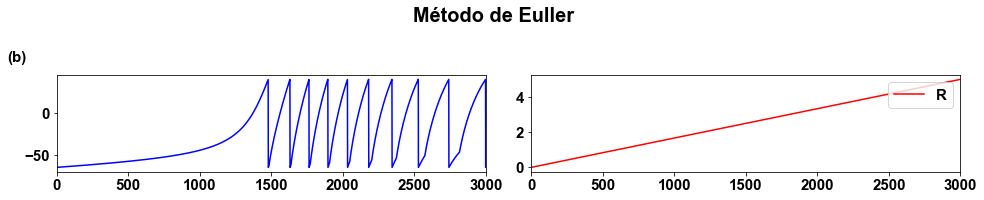

In [15]:
plt.rc('font', **font)
fig = plt.figure(figsize=(13.50,10.50))
fig.subplots_adjust(left=0.05, bottom=0.07, right=0.98,
                    top=0.89, wspace=0.236, hspace=0.35)
fig.suptitle('Método de Euller', fontsize=sizefonte+5, weight="bold")
linhas = 5
colunas = 4
ax1 = plt.subplot2grid((linhas, colunas), (0, 0), colspan=2)
ax1.text(-0.07, 1.25, '(b)', transform=ax1.transAxes,
      fontsize=sizefonte, fontweight='bold', va='top', ha='right')
plt.xlim(0,temSim)
plt.plot(v_b, 'b');

ax2 = plt.subplot2grid((linhas, colunas), (0, 2), colspan=2)
plt.plot(alpha, 'r', label='R')
ax2.legend(loc='upper right')
plt.xlim(0,temSim);

### Se colocarmos uma corrente que vai aumentando progressivamente, partindo de 0 até 5 nA, ele dispara cedo no momento no tempo igual a 1.479 segundos. Se essa corrente aumentar de forma mais rapida, por exemplo indo de 0 a 15nA nos primeiros 3 segundos, o neuronio dispara mais cedo em 1.439 segundos

## c) O potencial de membrana do neurônio descrito depende do valor da corrente externa injetada. Construa o gráfico f x Iinj, em que f é a taxa de disparos do neurônio no período de simulação.

In [17]:
tam = 7
v_c = [np.zeros(temSim+1) for i in range(tam)]
v_I = [np.zeros(temSim+1) for i in range(tam)]
v_d = [np.zeros(temSim+1) for i in range(tam)]
v_c_count = [0 for i in range(tam)]

for i in range(tam):
    v_c[i][0] = vrest
    
for i in range(temSim+1):
    v_I[0][i] = 5
    v_I[1][i] = 15
    v_I[2][i] = 25
    v_I[3][i] = 35
    v_I[4][i] = 45
    v_I[5][i] = 55
    v_I[6][i] = 65
    
for i in range(0, temSim-1):
    alphaN, betaN = n_enquacao(v[i],vrest)
    alphaM, betaM = m_enquacao(v[i],vrest)
    alphaH, betaH = h_enquacao(v[i],vrest)

    condutancia_K[i] = g_K*(pow(n[i],4))
    condutancia_Na[i] = g_Na*(pow(m[i],3))*h[i]

    I_Na[i] = condutancia_Na[i]*(v[i]-E_Na)
    I_K[i] = condutancia_K[i]*(v[i]-E_k)
    I_Leak[i] = g_Leak*(v[i]-E_Leak)

    for j in range(len(v_c)):
        entrada = (I_corrente[i] * v_I[j][i])- (I_Na[i] + I_K[i] + I_Leak[i])
        v_c[j][i+1] = v_c[j][i] + dt * (entrada*(1/c))
        if v_c[j][i+1] > vth:
            v_c[j][i+1] = vrest
            v_c_count[j] +=1
            v_d[j][i] = 1

    m[i+1] = m[i] + (alphaM * (1-m[i]) - betaM * m[i])*dt
    n[i+1] = n[i] + (alphaN * (1-n[i]) - betaN * n[i])*dt
    h[i+1] = h[i] + (alphaH * (1-h[i]) - betaH * h[i])*dt

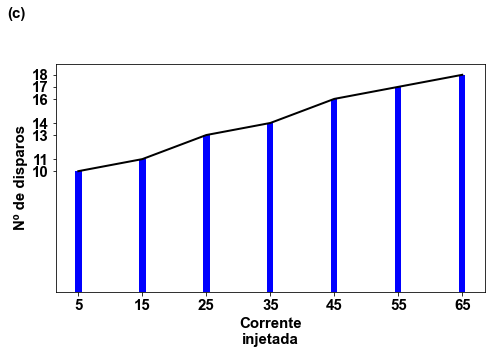

In [18]:
fig = plt.figure(figsize=(13.50,10.50))
fig.subplots_adjust(left=0.05, bottom=0.07, right=0.98,
                    top=0.89, wspace=0.236, hspace=0.35)
ax1 = plt.subplot2grid((linhas, colunas), (2, 0), colspan=2, rowspan=2)
ax1.text(-0.07, 1.25, '(c)', transform=ax1.transAxes,
      fontsize=sizefonte, fontweight='bold', va='top', ha='right')

injetValues = [v_I[0][0], v_I[1][0], v_I[2][0], v_I[3][0], v_I[4][0], v_I[5][0], v_I[6][0]]
plt.yticks(v_c_count)
plt.xticks(injetValues)
ax1.set_xlabel("Corrente\ninjetada", fontsize=sizefonte, fontweight='bold')
ax1.set_ylabel("Nº de disparos", fontsize=sizefonte, fontweight='bold')
plt.plot(injetValues, v_c_count, 'k', linewidth=2)
plt.bar(injetValues, v_c_count,  width=1, color='b');

### Conforme aumentamos a corrente de entrada, o valor de disparos aumenta também e de forma linear.

## d) Construa o histograma dos intervalos entre disparos para o neurônio descrito

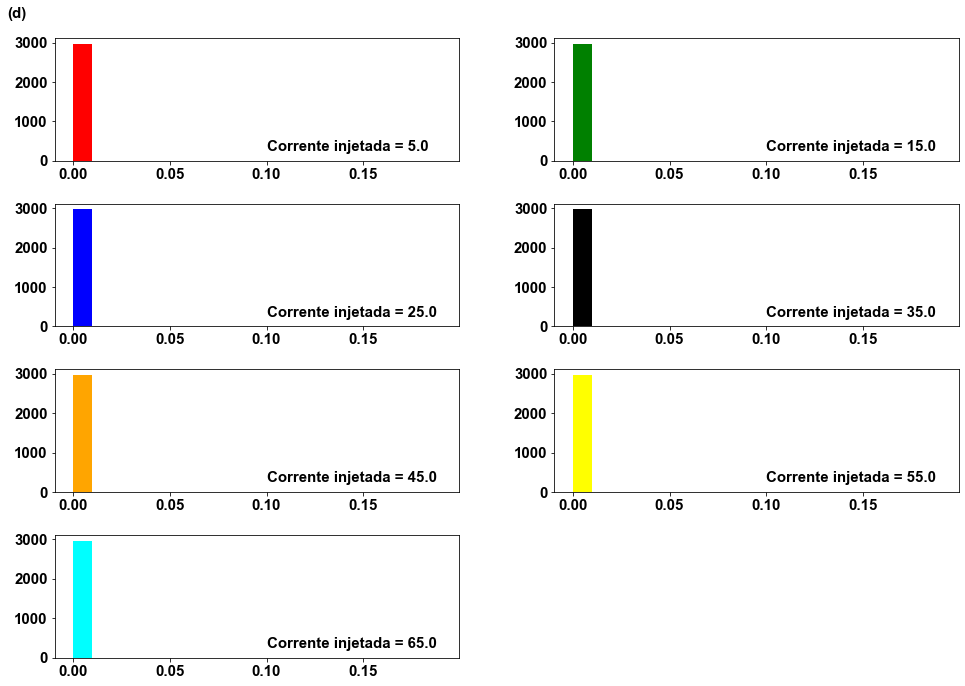

In [19]:
intervals = [np.zeros(temSim+1) for i in range(tam)]
for i in range(len(intervals)):
    intervals[i] = diff(v_d[i])
    intervals[i] = intervals[i][where(intervals[i] >= 0)]

bins = np.arange(0, .2, .01)

fig = plt.figure(figsize=(13.50,10.50))
fig.subplots_adjust(left=0.05, bottom=0.07, right=0.98,
                    top=0.89, wspace=0.236, hspace=0.35)
colunas = 2
linhas = 4

ax1 = plt.subplot2grid((linhas, colunas), (0, 0))
ax1.text(-0.07, 1.25, '(d)', transform=ax1.transAxes,
      fontsize=sizefonte, fontweight='bold', va='top', ha='right')
plt.hist(intervals[0], bins=bins, color='r')
ax1.annotate('Corrente injetada = {}'.format(injetValues[0]), xy=(.1, 200), xytext=(.1, 250))

ax2 = plt.subplot2grid((linhas, colunas), (0, 1))
plt.hist(intervals[1], bins=bins, color='g')
ax2.annotate('Corrente injetada = {}'.format(injetValues[1]), xy=(.1, 200), xytext=(.1, 250))

ax3 = plt.subplot2grid((linhas, colunas), (1, 0))
plt.hist(intervals[2], bins=bins, color='b')
ax3.annotate('Corrente injetada = {}'.format(injetValues[2]), xy=(.1, 200), xytext=(.1, 250))

ax4 = plt.subplot2grid((linhas, colunas), (1, 1))
plt.hist(intervals[3], bins=bins, color='k')
ax4.annotate('Corrente injetada = {}'.format(injetValues[3]), xy=(.1, 200), xytext=(.1, 250))

ax5 = plt.subplot2grid((linhas, colunas), (2, 0))
plt.hist(intervals[4], bins=bins, color='orange')
ax5.annotate('Corrente injetada = {}'.format(injetValues[4]), xy=(.1, 200), xytext=(.1, 250))

ax6 = plt.subplot2grid((linhas, colunas), (2, 1))
plt.hist(intervals[5], bins=bins, color='yellow')
ax6.annotate('Corrente injetada = {}'.format(injetValues[5]), xy=(.1, 200), xytext=(.1, 250))

ax7 = plt.subplot2grid((linhas, colunas), (3, 0))
ax7.annotate('Corrente injetada = {}'.format(injetValues[6]), xy=(.1, 200), xytext=(.1, 250))
plt.hist(intervals[6], bins=bins, color='cyan');

### Como o intervalo de tempo entre os disparos se mantem constante, é natural que e o histograma mostre apenas uma barra no gráfico.

## e) Repita os itens c e d, porém considere agora que Iinj possui amplitude de 2 nA e sofre a influência de um ruído. Avalie a influência de diferentes magnitudes de ruído. 

In [21]:
tam = 7
v_e = [np.zeros(temSim+1) for i in range(tam)]
v_I = [np.zeros(temSim+1) for i in range(tam)]
ruido = [np.zeros(temSim+1) for i in range(tam)]
spikes = [np.zeros(temSim+1) for i in range(tam)]
v_e_count = [0 for i in range(tam)]

for i in range(tam):
    v_e[i][0] = vrest

for i in range(temSim+1):
    v_I[0][i] = 5
    v_I[1][i] = 10
    v_I[2][i] = 15
    v_I[3][i] = 20
    v_I[4][i] = 25
    v_I[5][i] = 30
    v_I[6][i] = 35
np.random.seed(1145)

# 0 é a média da distribuição normal | 1 is the standard deviation of the normal distribution | temSim+1 tamanho do ruido
ruido[0] = np.random.normal(0, 50, temSim+1)
ruido[1] = np.random.normal(0, 60, temSim+1)
ruido[2] = np.random.normal(0, 70, temSim+1)
ruido[3] = np.random.normal(0, 80, temSim+1)
ruido[4] = np.random.normal(0, 90, temSim+1)
ruido[5] = np.random.normal(0, 100, temSim+1)
ruido[6] = np.random.normal(0, 110, temSim+1)

for i in range(0, temSim-1):
    alphaN, betaN = n_enquacao(v[i],vrest)
    alphaM, betaM = m_enquacao(v[i],vrest)
    alphaH, betaH = h_enquacao(v[i],vrest)

    condutancia_K[i] = g_K*(pow(n[i],4))
    condutancia_Na[i] = g_Na*(pow(m[i],3))*h[i]

    I_Na[i] = condutancia_Na[i]*(v[i]-E_Na)
    I_K[i] = condutancia_K[i]*(v[i]-E_k)
    I_Leak[i] = g_Leak*(v[i]-E_Leak)

    for j in range(len(v_e)):
        entrada = (I_corrente[i] * v_I[j][i])- (I_Na[i] + I_K[i] + I_Leak[i])
        
        v_e[j][i+1] = v_e[j][i] + dt * (entrada * ruido[j][i] *(1/c))
        
        if v_e[j][i+1] > vth:
            v_e[j][i+1] = vrest
            v_e_count[j] +=1
            spikes[j][i] = 1

    m[i+1] = m[i] + (alphaM * (1-m[i]) - betaM * m[i])*dt
    n[i+1] = n[i] + (alphaN * (1-n[i]) - betaN * n[i])*dt
    h[i+1] = h[i] + (alphaH * (1-h[i]) - betaH * h[i])*dt

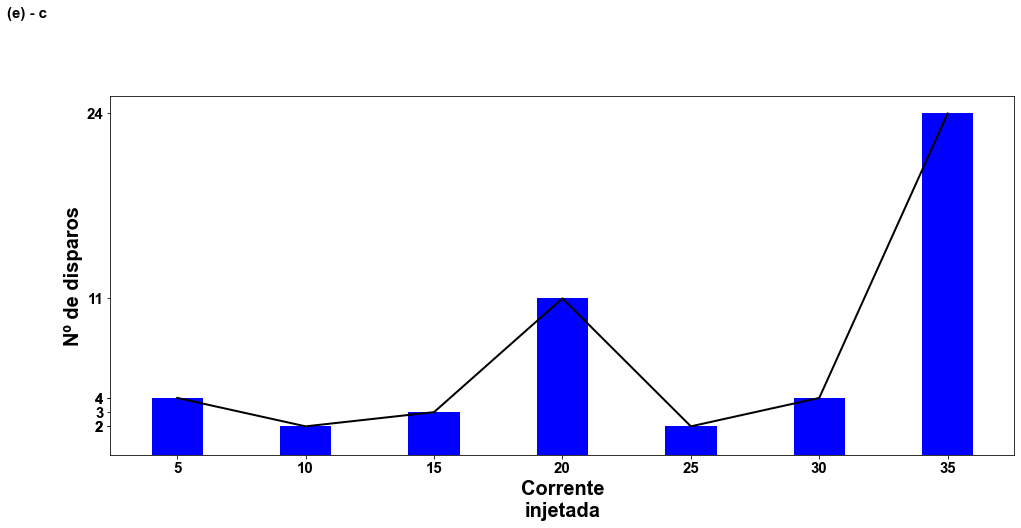

In [23]:
fig = plt.figure(figsize=(13.50,10.50))
fig.subplots_adjust(left=0.05, bottom=0.07, right=0.98,
                    top=0.89, wspace=0.236, hspace=0.35)
colunas = 3
linhas = 5
ax1 = plt.subplot2grid((linhas, colunas), (2, 0), colspan=3, rowspan=5)
ax1.text(-0.07, 1.25, '(e) - c', transform=ax1.transAxes,
      fontsize=sizefonte, fontweight='bold', va='top', ha='right')

injetValues = [v_I[0][0], v_I[1][0], v_I[2][0], v_I[3][0], v_I[4][0], v_I[5][0], v_I[6][0]]
plt.yticks(v_e_count)
plt.xticks(injetValues)
ax1.set_xlabel("Corrente\ninjetada", fontsize=sizefonte+5, fontweight='bold')
ax1.set_ylabel("Nº de disparos", fontsize=sizefonte+5, fontweight='bold')
plt.plot(injetValues, v_e_count, 'k', linewidth=2)
plt.bar(injetValues, v_e_count,  width=2, color='b');

### Com a injeção do ruido, o numero de disparos varia entre os valor de corrente injetada

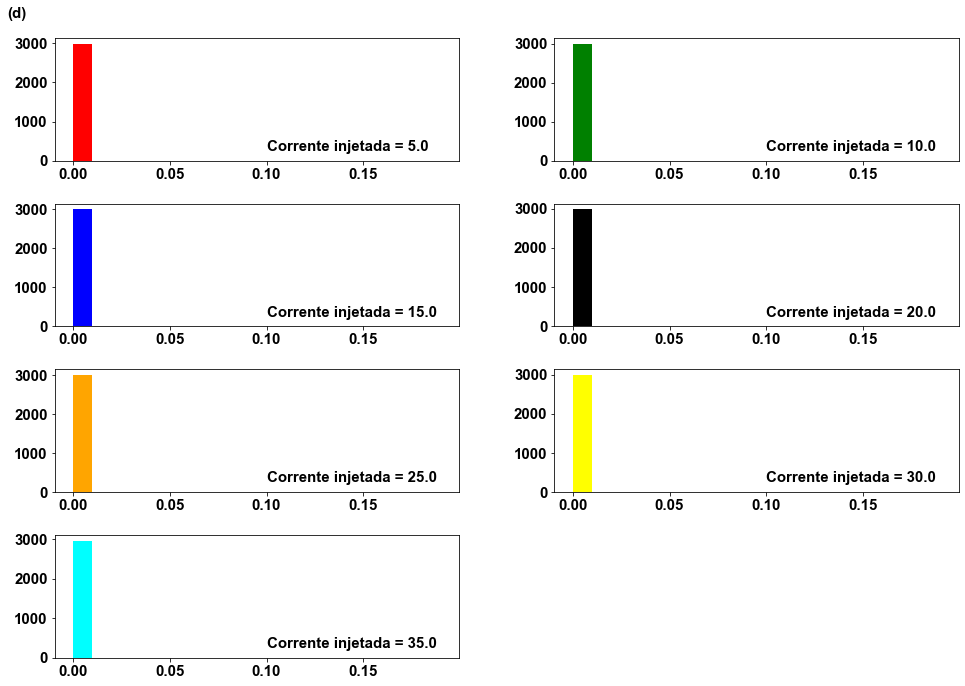

In [25]:
intervals = [np.zeros(temSim+1) for i in range(tam)]
for i in range(len(spikes)):
    intervals[i] = diff(spikes[i])
    intervals[i] = intervals[i][where(intervals[i] >= 0)]

bins = np.arange(0, .2, .01)

fig = plt.figure(figsize=(13.50,10.50))
fig.subplots_adjust(left=0.05, bottom=0.07, right=0.98,
                    top=0.89, wspace=0.236, hspace=0.35)
colunas = 2
linhas = 4

ax1 = plt.subplot2grid((linhas, colunas), (0, 0))
ax1.text(-0.07, 1.25, '(d)', transform=ax1.transAxes,
      fontsize=sizefonte, fontweight='bold', va='top', ha='right')
plt.hist(intervals[0], bins=bins, color='r')
ax1.annotate('Corrente injetada = {}'.format(injetValues[0]), xy=(.1, 200), xytext=(.1, 250))

ax2 = plt.subplot2grid((linhas, colunas), (0, 1))
plt.hist(intervals[1], bins=bins, color='g')
ax2.annotate('Corrente injetada = {}'.format(injetValues[1]), xy=(.1, 200), xytext=(.1, 250))

ax3 = plt.subplot2grid((linhas, colunas), (1, 0))
plt.hist(intervals[2], bins=bins, color='b')
ax3.annotate('Corrente injetada = {}'.format(injetValues[2]), xy=(.1, 200), xytext=(.1, 250))

ax4 = plt.subplot2grid((linhas, colunas), (1, 1))
plt.hist(intervals[3], bins=bins, color='k')
ax4.annotate('Corrente injetada = {}'.format(injetValues[3]), xy=(.1, 200), xytext=(.1, 250))

ax5 = plt.subplot2grid((linhas, colunas), (2, 0))
plt.hist(intervals[4], bins=bins, color='orange')
ax5.annotate('Corrente injetada = {}'.format(injetValues[4]), xy=(.1, 200), xytext=(.1, 250))

ax6 = plt.subplot2grid((linhas, colunas), (2, 1))
plt.hist(intervals[5], bins=bins, color='yellow')
ax6.annotate('Corrente injetada = {}'.format(injetValues[5]), xy=(.1, 200), xytext=(.1, 250))

ax7 = plt.subplot2grid((linhas, colunas), (3, 0))
ax7.annotate('Corrente injetada = {}'.format(injetValues[6]), xy=(.1, 200), xytext=(.1, 250))
plt.hist(intervals[6], bins=bins, color='cyan');

### Novamente atesto aqui minha derrota por não saber o que esta dando de errado nesse item.